<a href="https://colab.research.google.com/github/FlorianSong/MResAMS_DataAnalytics/blob/main/Workshop2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data analytics 2020
### Workshop 2 &ndash; Machine Learning Classics: Supervised Learning &ndash; 13th November 2020
##### Taught by: Florian Song, Linden Schrecker, Sophia Yaliraki

Much of today's workshop was taken from https://github.com/ageron/handson-ml2/ which in turn is based on the second edition of an O'Reilly book [Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) by Aurélien Geron.

### Overview & Outline


#### Topics covered today:
1. Decision Trees
    * Predicting classes and class probabilities
    * Sensitivity to training set details
    * Regularisation
    * *Extra Material: Decision Tree Regression*
2. Ensemble Learning: Random Forests
    * Ensemble Learning
    * Bagging & Pasting
    * Random Forests
    * *Extra Material: Stacking*
3. Extra material: Support Vector Machines
    * Linear SVM Classification
    * Sensitivity to feature scales
    * Sensitivity to outliers
    * Large margin *vs* margin violations
    * Non-linear classification
    * The kernel trick
    * The Gaussian RBF Kernel for Support Vector Machines


Firstly, some house-keeping. We need to check if we have all the necessary libraries installed. For this we can use the following boiler plate code:

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# all the functions from sklearn needed for this workshop
import sklearn
from sklearn.datasets import make_moons, make_circles, load_iris, load_wine
from sklearn.svm import LinearSVC, SVC, SVR
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.tree.export import export_text
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.tree.export module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


# 1. Decision Trees

- Versatile Machine Learning algorithms for both classification and regression
- Fundamental components of **Random Forests**
- Pros: 
    * require very little data preparation
    * make very few assumptions about training data
    * very easy to comprehend and visualise
    * predictions are very fast
- Contras: 
    * the default algorithm (CART) is greedy, i.e. it produces a solution that’s reasonably good but not guaranteed to be optimal (the optimal solution is intractable even for small datasets)
    * Very sensitive to data set variations -- small details lead to large changes in the model

Good documentation: https://scikit-learn.org/stable/modules/tree.html

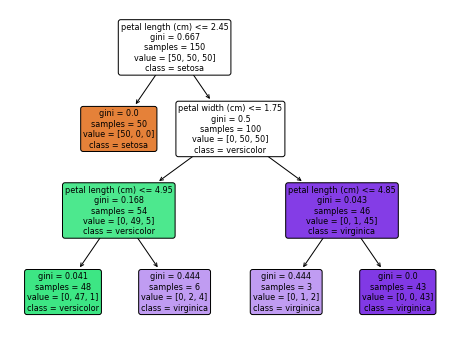

In [2]:
iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=3)
tree_clf.fit(X, y)

plt.figure(figsize=(8,6))
plot_tree(tree_clf,
          feature_names=iris.feature_names[2:],
          class_names=iris.target_names,
          rounded=True,
          filled=True
)
plt.show() #This line is only here to suppress the plot_tree output.

- Each white box represents a question, which can either be true or false
- Each coloured box represents a *leaf node*, which gives the final classification
- The `gini` values refer to the Gini impurity  
$
G_i = 1 - \sum\limits_{k=1}^{n}{{p_{i,k}}^2},
$  
where $p_{i,k}$ is the ratio of class $k$ instances among the training instances in the $i$th node.
- A node is "pure” (`gini=0`) if all training instances it applies to belong to the same class
- The depth-2 left node (versicolor) has a `gini` score equal to $1- \frac{0}{54}^2 - \frac{49}{54}^2 - \frac{5}{54}^2 \approx 0.168$.
- Notice how these numbers correspond to `value` list

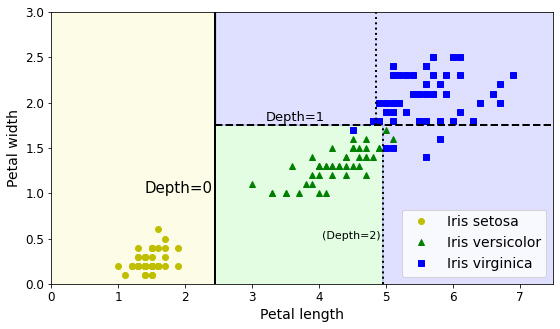

In [3]:
def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True, 
                           labels = ("Iris setosa", "Iris versicolor", "Iris virginica"), 
                           custom_cmap = ['#fafab0','#a0faa0','#9898ff']) :
    x1s = np.linspace(axes[0], axes[1], 500)
    x2s = np.linspace(axes[2], axes[3], 500)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(custom_cmap)
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label=labels[0])
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label=labels[1])
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "bs", label=labels[2])
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(9, 5))
plot_decision_boundary(tree_clf, X, y, legend=True)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)


plt.show()

### Predicting classes and class probabilities

- Classes are predicted by starting at the *root node* at the top of the tree and progressing down the tree by answering the respective questions (e.g. is the petal length smaller than 2.45cm?) 
- Class probabilities are estimated by returning the ratio of training instances of class $k$ in this node
- For example, imagine a flower with petal length = 5cm and petal width = 1.5cm:
    * The predicted class is virginica, since petal length is >2.45cm (right route at depth=0), petal width is <1.75cm (left route at depth=1) and finally, petal length >4.95 cm (right route at depth=2).
    * The corresponding leaf node is the depth-3 second-from-the-left node (with samples=6), so the Decision Tree should output the following probabilities: 0% for Iris setosa (0/6), 33.33% for Iris versicolor (2/6), and 66.66% for Iris virginica (4/6).

In [4]:
tree_clf.predict([[5, 1.5]])

array([2])

In [5]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.33333333, 0.66666667]])

### Sensitivity to training set details

- Sadly, Decision Trees are very sensitive to small changes in the dataset. 
- Firstly, removing even one flower (the largest Iris versicolor) changes the Decision Tree immensely:

In [6]:
X[(X[:, 1]==X[:, 1][y==1].max()) & (y==1)] # widest Iris versicolor flower

array([[4.8, 1.8]])

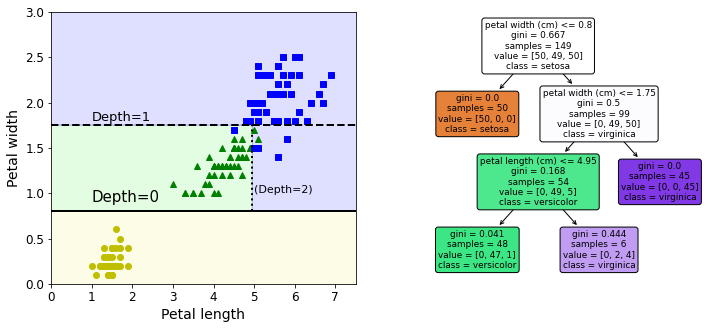

In [7]:
not_widest_versicolor = (X[:, 1]!=1.8) | (y!=1)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=3, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)


plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)

plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)
plt.plot([4.95, 4.95], [0.8, 1.75], "k:", linewidth=2)
plt.text(5, 1, "(Depth=2)", fontsize=11)

plt.subplot(1,2,2)

plot_tree(tree_clf_tweaked,
          feature_names=iris.feature_names[2:],
          class_names=iris.target_names,
          rounded=True,
          filled=True
)


plt.show()

- Furthermore, rotating the data can produce further changes, as decision trees can only produce boundaries along axes:

*N.B. for this simple data transformation, we can use a **rotation matrix**, defined like this:*
$R = \begin{pmatrix} \cos(\theta) & -\sin(\theta) \\ \sin(\theta) & \cos(\theta) \end{pmatrix} $ 

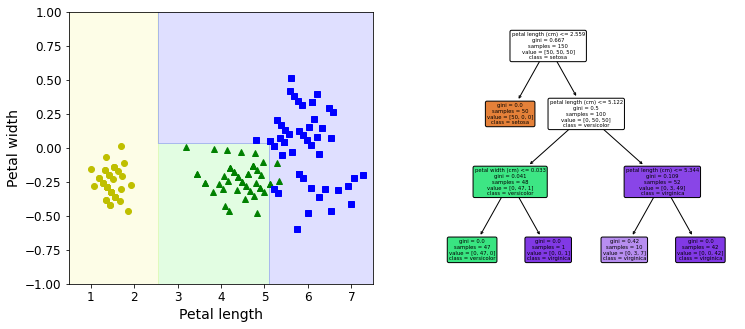

In [8]:
angle = np.pi / 180 * 20 # angle has to be in radians
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xr = X.dot(rotation_matrix)

tree_clf_r = DecisionTreeClassifier(max_depth=3)
tree_clf_r.fit(Xr, y)

plt.figure(figsize=(12,5))


plt.subplot(1,2,1)

plot_decision_boundary(tree_clf_r, Xr, y, axes=[0.5, 7.5, -1.0, 1])

plt.subplot(1,2,2)

plot_tree(tree_clf_r,
          feature_names=iris.feature_names[2:],
          class_names=iris.target_names,
          rounded=True,
          filled=True
)

plt.show()

### Regularisation

- To avoid overfitting, can use various parameters to restrict the Decision Tree:
    * `max_depth`: the maximum depth
    * `min_samples_split`: minimum number of samples a node must have before it can be split
    * `min_samples_leaf`: minimum number of samples a leaf node must have
    * `min_weight_fraction_leaf`: same as above but expressed as a fraction of the total number of weighted instances
    * `max_leaf_nodes`: maximum number of leaf nodes
    * `max_features`: maximum number of features that are evaluated for splitting at each node
    
For this part, we introduce a new dataset. More accurately, this is a dataset *generator*: `make_moons()`


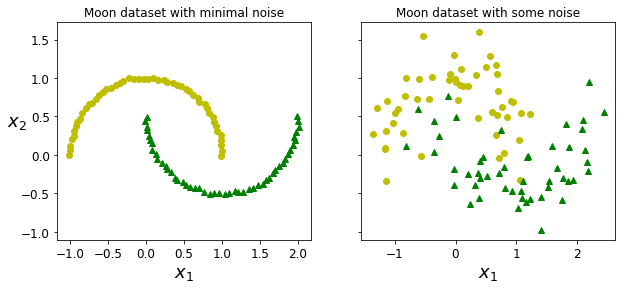

In [9]:
Xm_small, ym_small = make_moons(n_samples=100, noise=0.01)
Xm, ym = make_moons(n_samples=100, noise=0.25)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plt.plot(Xm_small[:, 0][ym_small==0], Xm_small[:, 1][ym_small==0], "yo")
plt.plot(Xm_small[:, 0][ym_small==1], Xm_small[:, 1][ym_small==1], "g^")
plt.xlabel(r"$x_1$", fontsize=18)
plt.ylabel(r"$x_2$", rotation=0, fontsize=18)
plt.title("Moon dataset with minimal noise")

plt.sca(axes[1])
plt.plot(Xm[:, 0][ym==0], Xm[:, 1][ym==0], "yo")
plt.plot(Xm[:, 0][ym==1], Xm[:, 1][ym==1], "g^")
plt.xlabel(r"$x_1$", fontsize=18)
plt.title("Moon dataset with some noise")


plt.show()


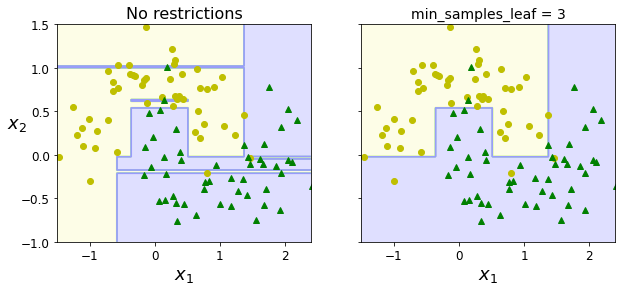

In [10]:
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=42)

deep_tree_clf1 = DecisionTreeClassifier()
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=3) #change this number to see how the regularisation works!
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")

plt.show()

### In-class challenge 1
- Below, you will find a line loading another inbuilt dataset from `sklearn`: the `wine` data. This data set is the result of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of 13 constituents found in each of the three types of wines.

- Use code from above to fit a Decision Tree to this data, to determine which of the 13 measured predictors are to be used to classify some wine into one of the three categories. *Make sure to use `train_test_split` to split your data into training and test datasets!* 

- What difference do the different regularisation parameters make?

- What's your prediction success rate? What does this say about the data? Run your Decision Tree a few times to see how the random number generator plays a big role! 

- *Hint:* plotting the decision tree may or may not end up a little confusing and unclear. You can use `print(export_tree(..., feature_names=...))` to get a text formatted version instead. 

In [11]:
wine = sklearn.datasets.load_wine()
# print(wine.DESCR) # Uncomment to get detailed dataset information

In [12]:
# 1, 2, 3, code!
X_wine, y_wine = load_wine(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X_wine, y_wine)

tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)

print(export_text(tree_clf))

np.sum(tree_clf.predict(X_test) == y_test)/len(y_test)

|--- feature_12 <= 755.00
|   |--- feature_11 <= 2.19
|   |   |--- feature_3 <= 17.50
|   |   |   |--- class: 1
|   |   |--- feature_3 >  17.50
|   |   |   |--- feature_4 <= 85.50
|   |   |   |   |--- class: 1
|   |   |   |--- feature_4 >  85.50
|   |   |   |   |--- class: 2
|   |--- feature_11 >  2.19
|   |   |--- feature_0 <= 13.17
|   |   |   |--- class: 1
|   |   |--- feature_0 >  13.17
|   |   |   |--- feature_4 <= 98.50
|   |   |   |   |--- class: 1
|   |   |   |--- feature_4 >  98.50
|   |   |   |   |--- class: 0
|--- feature_12 >  755.00
|   |--- feature_6 <= 2.24
|   |   |--- feature_1 <= 2.08
|   |   |   |--- class: 1
|   |   |--- feature_1 >  2.08
|   |   |   |--- class: 2
|   |--- feature_6 >  2.24
|   |   |--- class: 0



0.8666666666666667

###  Extra material: Decision tree regression

- Whilst decision trees are mostly used for classification, they can also be used for regression, as you can see below!

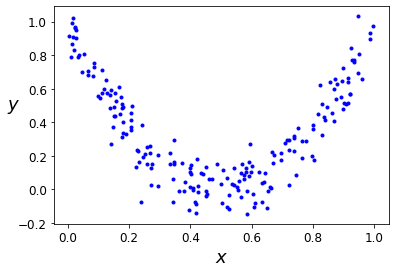

In [13]:
# Quadratic training set + noise
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

plt.plot(X, y, "b.")
plt.xlabel("$x$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.show()

In [14]:
tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2)

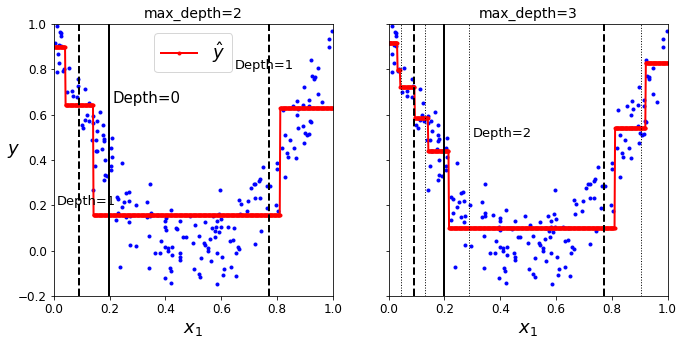

In [15]:
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg2 = DecisionTreeRegressor(max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(11, 5), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)


plt.show()

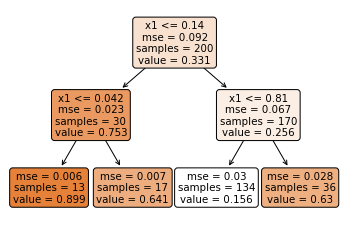

In [16]:
plot_tree(
        tree_reg1,
        feature_names=["x1"],
        rounded=True,
        filled=True
    )
plt.show()

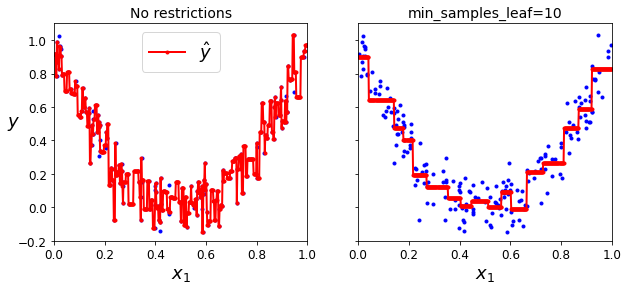

In [17]:
tree_reg1 = DecisionTreeRegressor()
tree_reg2 = DecisionTreeRegressor(min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)


plt.show()

# 2. Ensemble Learning: Random Forests

- Ensemble learning stems from the concept that aggregating many predictions of a group of predictors gives better predictions that just the best individual predictor (*wisdom of the crowd*).

<img src="https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0701.png" alt="Ensemble learning" style="width:60%" />

- A *random forest* is an ensemble method build from a group of Decision Trees trained on a different random subset of the training data. 
- To predict, obtain the predictions of all individual trees and choose the option with the most votes. 



### Ensemble Learning

Ensemble methods work best when the predictors are as **independent**
from each other as possible. 

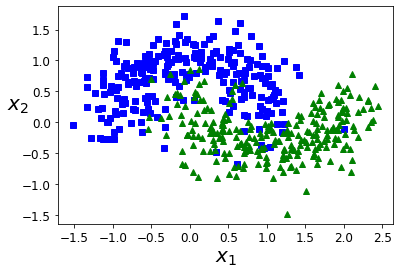

In [18]:
X, y = make_moons(n_samples=500, noise=0.30)
X_train, X_test, y_train, y_test = train_test_split(X, y)

plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
plt.show()

In [19]:
log_clf = LogisticRegression(solver="lbfgs")
rnd_clf = RandomForestClassifier(n_estimators=100)
svm_clf = SVC(gamma="scale", probability=True)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard') # Change this to 'soft' and see what happens!

voting_clf.fit(X_train, y_train)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print( accuracy_score(y_test, y_pred), clf.__class__.__name__)

0.936 LogisticRegression
0.944 RandomForestClassifier
0.952 SVC
0.96 VotingClassifier


*Soft learning* uses the averaged class probabilities instead of hard predictions. Try this out by changing the voting mechanism in the `VotingClassifier` to `'soft'`. 

### Bagging & Pasting

- Ensemble methods can work either by using a diverse range of prediction algorithms or by using the same algorithm and **training it on different random subsets** of the training data.
- When sampling is performed *with* replacement, this method is called **bagging** (short for bootstrap aggregating). When sampling is performed *without* replacement, it is called **pasting**.
- Predictions are typically performed by taking the most frequent prediction or the average of all predictions. 

<!--- <img src="https://hackernoon.com/hn-images/0*zrm9Q8twgrq8lfLk." alt="bagging" style="width:80%" align="middle" /> -->

<img src="https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0704.png" alt="bagging and pasting" style="width:60%" align="middle"/>  


In [20]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print("One single tree:", accuracy_score(y_test, y_pred_tree))

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)

bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)
print("A whole forest:", accuracy_score(y_test, y_pred))

One single tree: 0.864
A whole forest: 0.96


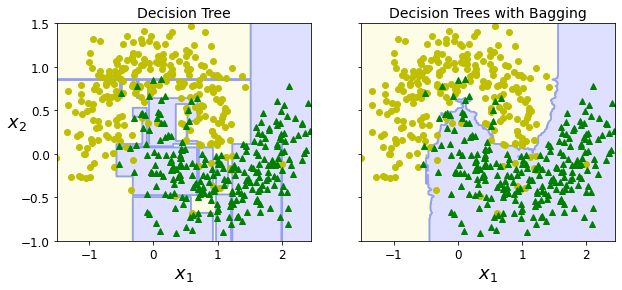

In [21]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], iris = False)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], iris = False)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

### Random forests

- This is simply an *ensemble of decision trees*, usually using the *bagging* method with `max_samples` set to the same as the size of the training dataset.
- The two codes below are almost identical: 

In [22]:
# This: 
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

# is almost identical to: 
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16)

rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

# Let's compare:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions

1.0

A great advantage of random forests is that they can assign importance to each feature by looking at how much the tree nodes that use that feature reduce impurity on average (across all trees in the forest)

In [23]:
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09730531819399119
sepal width (cm) 0.02761168688377011
petal length (cm) 0.426528232763164
petal width (cm) 0.4485547621590748


### In-class challenge 2

- Remember the wine dataset? The Decision Tree earlier on worked ok, but the prediction success rate varied wildly and wasn't all that good either... 
- What about fitting a Random Forest? *Again, don't forget to split training and test!*
- Which of the features were the most important in the predictions?

In [24]:
X_wine, y_wine = load_wine(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X_wine, y_wine)

rnd_clf = RandomForestClassifier(n_estimators=500)

rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

print(accuracy_score(y_pred_rf, y_test))
for name, score in zip(load_wine()["feature_names"], rnd_clf.feature_importances_):
    print(round(score,2), name)

1.0
0.13 alcohol
0.04 malic_acid
0.02 ash
0.03 alcalinity_of_ash
0.03 magnesium
0.05 total_phenols
0.16 flavanoids
0.02 nonflavanoid_phenols
0.02 proanthocyanins
0.15 color_intensity
0.09 hue
0.11 od280/od315_of_diluted_wines
0.16 proline


### Extra Material: Stacking 
<img src="https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0712.png" alt="stacking" style="width:40%" align="left" />  
- Simple: instead of using trivial functions (such as hard voting) to aggregate the predictions of all predictors in an ensemble, train a model to perform this aggregation!

<br>
<br>
<img src="https://1.bp.blogspot.com/-tgUf5CDQm8A/XQfjAId11cI/AAAAAAAARC8/P7MG69COxh8mMjuJaL0NNLXqQgmvNzcawCLcBGAs/s1600/64369119_2391298877618340_4851478784206962688_n.jpg" alt="stacking" style="width:40%" align="right" />  



- How to train this? Split the training dataset into two halves and train layer 1 ("Predict" in the graphic above) using one half and layer 2 ("Blending") using the other half. 


<img src="https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0713.png" alt="training stacking 1" style="width:50%" align="left">
<img src="https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0714.png" alt="training stacking 2" style="width:40%" align="right">
    

Sadly, Sci-kit learn does not have an inbuild function for this. See the code below for an implementation of stacking. 

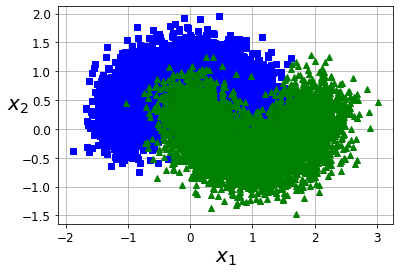

In [25]:
X, y = make_moons(n_samples=10000, noise=0.3)

plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.grid(True, which='both')
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
plt.show()


X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=1000)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=1000)

### Proceed with care: the following code may run for *a while*...

In [26]:
random_forest_clf = RandomForestClassifier(n_estimators=100)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100)
svm_clf = LinearSVC()
mlp_clf = MLPClassifier(max_iter = 1000)

estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)
    
print("Accuracies:", [estimator.score(X_val, y_val) for estimator in estimators])

Training the RandomForestClassifier()
Training the ExtraTreesClassifier()
Training the LinearSVC()
Training the MLPClassifier(max_iter=1000)
Accuracies: [0.907, 0.907, 0.857, 0.925]


In [27]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
        X_val_predictions[:, index] = estimator.predict(X_val)
    
X_val_predictions

array([[0., 0., 0., 0.],
       [1., 1., 1., 1.],
       [0., 0., 0., 0.],
       ...,
       [1., 1., 1., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)

In [28]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True)
rnd_forest_blender.fit(X_val_predictions, y_val)


X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)
    
y_pred = rnd_forest_blender.predict(X_test_predictions)

accuracy_score(y_test, y_pred)

0.912

Sadly in this case, the `MLPClassifier` actually does better on its own! 

# 3. Extra Material

## Support Vector Machines

- A powerful and versatile machine learning model
- Well-suited for classifying small- and medium-sized datasets
- Capable of performing:
    * Linear & Non-linear classification
    * Regression
    * Outlier detection
    
A good resource for more information is sklearn's own documentation on SVMs, to be found here: https://scikit-learn.org/stable/modules/svm.html


<img src="https://upload.wikimedia.org/wikipedia/commons/7/72/SVM_margin.png" alt="SVM" width="300" align="right"/>

### Linear SVM Classification

- Objective is to find a line (i.e. collection of points) satisfying $ w^Tx + b=0$, the **decision boundary**
- Predictions:  
$ \hat y = \begin{cases}
      \text{class A} & \text{if $w^T x + b < 0$}\\
      \text{class B} & \text{if $w^T x + b >= 0$}    
    \end{cases}       
$
- Important to note: SVMs only provide binary predictions, as opposed to probabilistic values like in logistic regressions!

- In the following, we see an example of this: 
    - Again, we use the iris dataset
    - However, we only use a subset of the data here: Iris setosa and Iris versicolor only, no Iris virginica
    - Use the `SVC` command, with `kernel="linear"` to fit a simple linear SVM

In [29]:
iris = load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)

SVC(C=inf, kernel='linear')

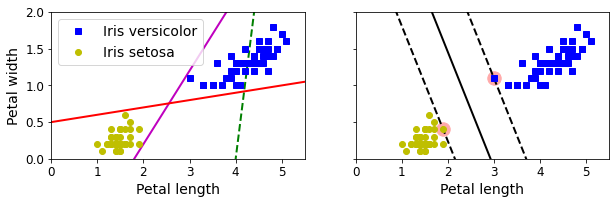

In [30]:
# Bad models
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()

From the plots, we can see how a SVM works:
- The plot on the left shows: 
    * decision boundaries of three possible linear classifiers
    * both purple and red classifiers are good boundaries for the data
    * the dashed green line is so bad that it does not even separate the classes properly
- The plot on the right shows how an SVM works:
    * The solid black line represents the decision boundary of an SVM classifier
    * This line stays as far away from the closest training instances as possible
    * Think of fitting the widest possible street (represented by the parallel dashed lines)
    
    
### Sensitivity to feature scales

In the left plot below, the vertical scale is much larger than the horizontal scale, so the widest possible street is close to horizontal. After feature scaling (e.g., using Scikit-Learn’s `StandardScaler`), the decision boundary in the right plot looks much better.

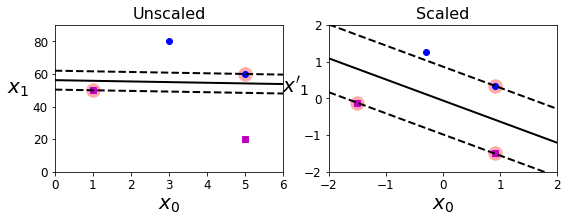

In [31]:
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100)
svm_clf.fit(Xs, ys)

plt.figure(figsize=(9,2.7))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$    ", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf.fit(X_scaled, ys)

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, -2, 2)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x'_1$  ", fontsize=20, rotation=0)
plt.title("Scaled", fontsize=16)
plt.axis([-2, 2, -2, 2])

plt.show()

### Sensitivity to outliers

Linear SVMs only work when the data is linearly separable. They are also sensitive to outliers as you can see from the second plot below. 

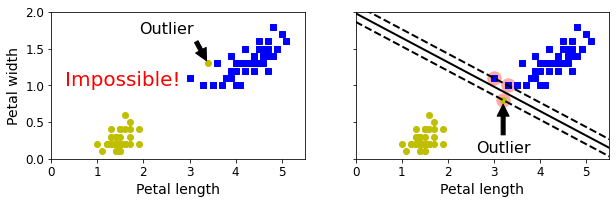

In [32]:
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Impossible!", fontsize=20, color="red")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[0][0], X_outliers[0][1]),
             xytext=(2.5, 1.7),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[1][0], X_outliers[1][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.show()

### Large margin *vs* margin violations 

- To avoid these issues, use *soft margin classification*
- Objective: find a good balance between width of decision boundary and *margin violations*
- This can be achieved through the `hinge` loss function, for a plot, see the first cell below.
- `sklearn`'s `LinearSVC` function also takes a hyperparameter: `C`. This is similar to the identically named hyperparameter in `LogisticRegression` and represents the tradeoff between misclassification and simplicity of the decision boundary. In general, the larger `C`, the fewer margin violations but the smaller the margin. Beware of overfitting! A value of `C=1.0` is generally a good start. 

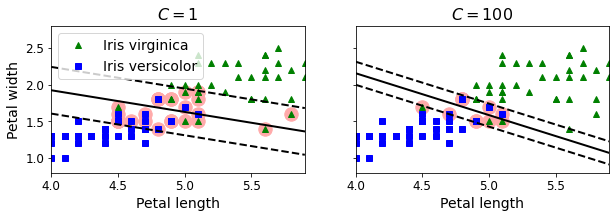

In [33]:
iris = load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge")
svm_clf2 = LinearSVC(C=100, loss="hinge")

scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ])
scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

# Convert to unscaled parameters
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Find support vectors (LinearSVC does not do this automatically)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]


fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

plt.show()

### Non-linear classification

What if data is not *linearly separable*? One approach would be to add more features, e.g. polynomial features.

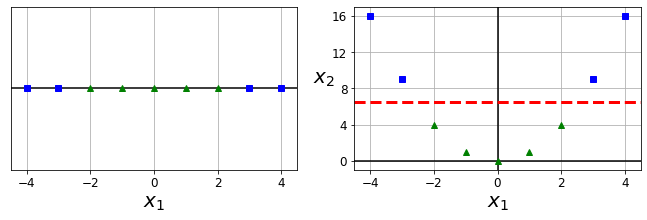

In [34]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10, 3))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$x_1$", fontsize=20)
plt.axis([-4.5, 4.5, -0.2, 0.2])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$  ", fontsize=20, rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])

plt.subplots_adjust(right=1)

plt.show()

To illustrate this idea on a more complex data set, let's consider the moons dataset: 

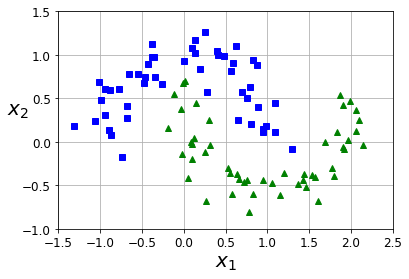

In [35]:
X, y = make_moons(n_samples=100, noise=0.15)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In `sklearn`, we can use `PolynomialFeatures`, just like in the polynomial regressions from last time, to add additional features to the data. 

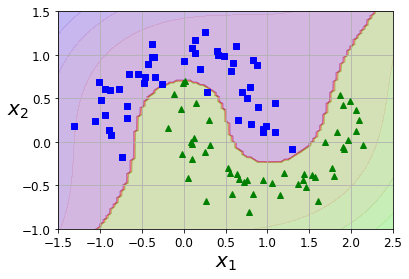

In [36]:
polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", max_iter=10**5))
    ])

polynomial_svm_clf.fit(X, y)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()

### The kernel trick

High-order polynomial features will cause the number of features to explode. This problem can be solved through the *kernel trick*.

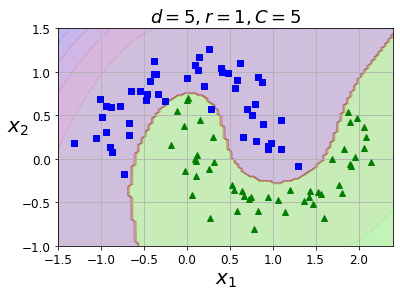

In [37]:
d, r, C = 5, 1, 5 # Play around with these values!

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=d, coef0=r, C=C))
    ])
poly_kernel_svm_clf.fit(X, y)

plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d={}, r={}, C={}$".format(d,r,C), fontsize=18)
plt.show()

### The Gaussian RBF Kernel for Support Vector Machines

- Another technique to tackle nonlinear problems is to add features computed using a *similarity function*, which measures how much each instance resembles a particular landmark. 
- In the case of the Gaussian Radial Basis Function (RBF): 
$
{\displaystyle \phi_{\gamma}(\mathbf{x}, \boldsymbol{\ell})} = {\displaystyle \exp({\displaystyle -\gamma \left\| \mathbf{x} - \boldsymbol{\ell} \right\|^2})}
$



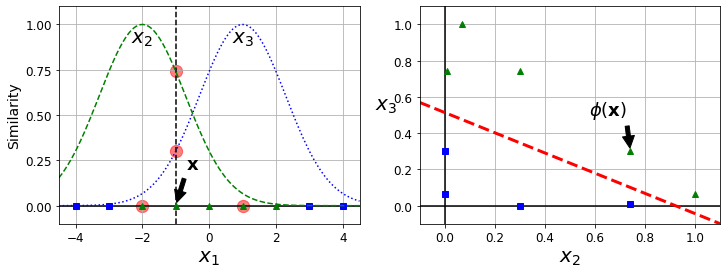

Phi(-1.0, -2) = [0.74081822]
Phi(-1.0, 1) = [0.30119421]


In [38]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3
landmark1 = -2
landmark2 = 1

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, landmark1, gamma)
x3s = gaussian_rbf(x1s, landmark2, gamma)

X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
XK = np.c_[gaussian_rbf(X1D, landmark1, gamma), 
           gaussian_rbf(X1D, landmark2, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10.5, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=-1, color='k', ls="--")
plt.scatter(x=[landmark1, landmark2, -1, -1], 
            y=[0, 0,  
               gaussian_rbf(np.array([[-1]]), landmark1, gamma)[0], 
               gaussian_rbf(np.array([[-1]]), landmark2, gamma)[0]], 
            s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity", fontsize=14)
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)
plt.show()

x1_example = X1D[3, 0]
for landmark in (landmark1, landmark2):
    k = gaussian_rbf(np.array([[x1_example]]), np.array([[landmark]]), gamma)
    print("Phi({}, {}) = {}".format(x1_example, landmark, k))

In [39]:
X, y = make_moons(n_samples=100, noise=0.15)

rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ])
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

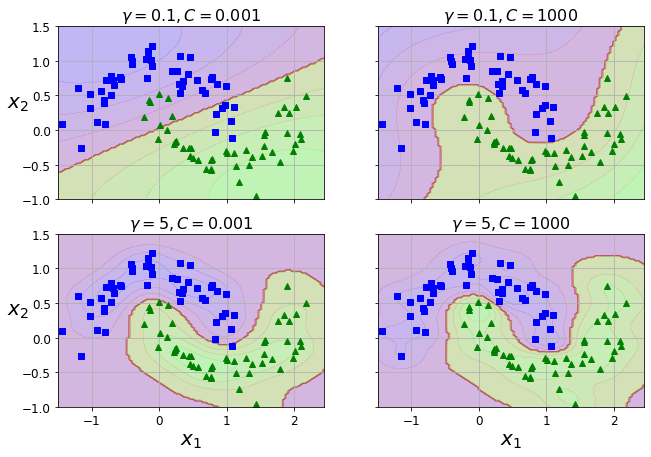

In [40]:
gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

plt.show()

# Take-home challenge: Classifying biodegradability

- This week, we will look at the QSAR biodegradation dataset available [here](https://archive.ics.uci.edu/ml/datasets/QSAR+biodegradation). This dataset contains 41 molecular descriptors and 1 experimental class: ready biodegradable (RB) and not ready biodegradable (NRB). As you can tell, this dataset lends itself nicely to using decision trees and random forests. 
- Firstly, have a look at the data webpage linked above. Familiarise yourself with all the descriptors and think about which ones may have more predicting power over others. 
- Using a package of your choice (`csv` or `pandas` or something else), read in the dataset and encode the class variable as integers. The direct link to the dataset is here (this works directly with pandas.read_csv!): `https://archive.ics.uci.edu/ml/machine-learning-databases/00254/biodeg.csv` 
- Fit a decision tree (*training/test*!). What's the prediction success rate? Find out the spread of the success rate (mean, variance).
- Fit a random forest. Does this improve things? 
- Can you tune the parameters to get an even better prediction rate? 
- Which parameters are more important than others? What happens when you train on a subset of parameters? Play around with this to see what happens. 
- *Bonus:* In the associated paper, the authors used - amongst other methods - Support Vector Machines fitted to the data. Read to the extra material on SVMs and try to fit an SVM to this data. How does it perform compared to the random forest?  
- *Bonus 2:* Implement a simple stacking ensemble method with your choice of predictors. Again, can you improve your high-score?
- *Bonus 3:* Using at least 5-fold cross-validation (https://scikit-learn.org/stable/modules/cross_validation.html) to obtain a range of predictions, report your average precision for your best model. *Hint: if you'd like to use a Stacking classifier, have a look at the `mlxtend` package.*



In [41]:
# Data loading and encoding the outcome variable

import pandas as pd
biodeg = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00254/biodeg.csv", sep=";", header=None)
biodeg = biodeg.to_numpy()

X_biodeg = biodeg[:, :-1].astype(np.float)
y_biodeg = biodeg[:, -1].astype(np.str)

y_biodeg = np.array([0 if i == "NRB" else 1 for i in y_biodeg]).astype(np.int)


In [42]:
# Fitting a decision tree and reporting a success score

X_biodeg_train, X_biodeg_test, y_biodeg_train, y_biodeg_test = train_test_split(X_biodeg, y_biodeg)
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_biodeg_train, y_biodeg_train)
decision_tree.score(X_biodeg_test, y_biodeg_test)

0.8106060606060606

In [43]:
# Record the scores of 500 Decision trees and get the mean and standard deviation of all scores

scores = []
for i in range(500):
    X_biodeg_train, X_biodeg_test, y_biodeg_train, y_biodeg_test = train_test_split(X_biodeg, y_biodeg)
    scores += [DecisionTreeClassifier().fit(X_biodeg_train, y_biodeg_train).score(X_biodeg_test, y_biodeg_test)]
print(np.mean(scores), np.std(scores))

0.810030303030303 0.023753623279753305


In [44]:
# Fit a random forest to the data

X_biodeg_train, X_biodeg_test, y_biodeg_train, y_biodeg_test = train_test_split(X_biodeg, y_biodeg)
random_forest = RandomForestClassifier(n_estimators=500)
random_forest.fit(X_biodeg_train, y_biodeg_train)
    
random_forest.score(X_biodeg_test, y_biodeg_test)

0.8939393939393939

In [45]:
# Run 50 random forests, each with 100 trees, to get the average score and std deviation

scores = []
for i in range(50):
    X_biodeg_train, X_biodeg_test, y_biodeg_train, y_biodeg_test = train_test_split(X_biodeg, y_biodeg)
    scores += [RandomForestClassifier(n_estimators=100).fit(X_biodeg_train, y_biodeg_train).score(X_biodeg_test, y_biodeg_test)]
print(np.mean(scores), np.std(scores))

0.8717424242424242 0.01955088602004936


In [46]:
# Get information about the importance of each predictor variable
# Header names were taken from the paper (downloadable excel file)

header_names = np.array( ["SpMax_L", "J_Dz(e)", "nHM", "F01[N-N]", "F04[C-N]", "NssssC", "nCb-", "C%", "nCp", "nO", "F03[C-N]", "SdssC", "HyWi_B(m)", "LOC", "SM6_L", "F03[C-O]", "Me", "Mi", "nN-N", "nArNO2", "nCRX3", "SpPosA_B(p)", "nCIR", "B01[C-Br]", "B03[C-Cl]", "N-073", "SpMax_A", "Psi_i_1d", "B04[C-Br]", "SdO", "TI2_L", "nCrt", "C-026", "F02[C-N]", "nHDon", "SpMax_B(m)", "Psi_i_A", "nN", "SM6_B(m)", "nArCOOR", "nX"])
X_biodeg_train, X_biodeg_test, y_biodeg_train, y_biodeg_test = train_test_split(X_biodeg, y_biodeg)
random_forest = RandomForestClassifier(n_estimators=1000).fit(X_biodeg_train, y_biodeg_train)
ordered = random_forest.feature_importances_.argsort()[::-1]
for (i, name, score) in zip(ordered, header_names[ordered], random_forest.feature_importances_[ordered]):
    print("{}th feature:".format(str(i).rjust(2)) , str(round(score,3)).rjust(5),  name)

35th feature:   0.1 SpMax_B(m)
 0th feature: 0.075 SpMax_L
38th feature: 0.071 SM6_B(m)
21th feature: 0.066 SpPosA_B(p)
26th feature: 0.059 SpMax_A
14th feature: 0.041 SM6_L
12th feature: 0.036 HyWi_B(m)
36th feature: 0.034 Psi_i_A
11th feature: 0.033 SdssC
 1th feature: 0.032 J_Dz(e)
29th feature: 0.031 SdO
17th feature: 0.029 Mi
 9th feature: 0.029 nO
15th feature: 0.028 F03[C-O]
16th feature: 0.027 Me
 7th feature: 0.027 C%
13th feature: 0.027 LOC
30th feature: 0.026 TI2_L
37th feature: 0.025 nN
33th feature: 0.025 F02[C-N]
 2th feature: 0.021 nHM
27th feature: 0.019 Psi_i_1d
 6th feature: 0.018 nCb-
 4th feature: 0.017 F04[C-N]
 8th feature: 0.016 nCp
10th feature: 0.016 F03[C-N]
40th feature: 0.013 nX
 5th feature: 0.012 NssssC
32th feature: 0.011 C-026
34th feature:  0.01 nHDon
22th feature: 0.009 nCIR
39th feature: 0.007 nArCOOR
31th feature: 0.004 nCrt
24th feature: 0.002 B03[C-Cl]
 3th feature: 0.002 F01[N-N]
18th feature: 0.001 nN-N
19th feature: 0.001 nArNO2
23th feature: 0.

In [47]:
# Get the top n predictors and train only with those

top_predictors = random_forest.feature_importances_.argsort()[-17:][::-1]
X_biodeg_new = X_biodeg[:, top_predictors]

X_biodeg_train_new, X_biodeg_test_new, y_biodeg_train_new, y_biodeg_test_new = train_test_split(X_biodeg_new, y_biodeg)

new_random_forest = RandomForestClassifier(n_estimators=500)
new_random_forest.fit(X_biodeg_train_new, y_biodeg_train_new)

new_random_forest.score(X_biodeg_test_new, y_biodeg_test_new)

0.8484848484848485

In [48]:
# Bonus 1: Fitting an SVM

svm_rbf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf"))
    ])

svm_rbf.fit(X_biodeg_train, y_biodeg_train)

y_biodeg_pred_svm = svm_rbf.predict(X_biodeg_test)
accuracy_score(y_biodeg_pred_svm, y_biodeg_test)

0.8863636363636364

In [49]:
# Bonus 2: Stacked ensemble learning

X_train_val, X_test, y_train_val, y_test = train_test_split(X_biodeg, y_biodeg)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val)
print(X_biodeg.shape, X_train.shape, X_val.shape, X_test.shape)

random_forest_clf = RandomForestClassifier(n_estimators=100)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100)
svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma="auto"))
    ])
mlp_clf = MLPClassifier(max_iter = 1000)


estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)
    
print("Accuracies:", [estimator.score(X_val, y_val) for estimator in estimators])

X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
        X_val_predictions[:, index] = estimator.predict(X_val)
        
        
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True)
rnd_forest_blender.fit(X_val_predictions, y_val)


X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)
    
y_pred = rnd_forest_blender.predict(X_test_predictions)

accuracy_score(y_test, y_pred)

(1055, 41) (593, 41) (198, 41) (264, 41)
Training the RandomForestClassifier()
Training the ExtraTreesClassifier()
Training the Pipeline(steps=[('scaler', StandardScaler()), ('svm_clf', SVC(gamma='auto'))])
Training the MLPClassifier(max_iter=1000)
Accuracies: [0.8636363636363636, 0.8686868686868687, 0.8737373737373737, 0.8636363636363636]


0.8977272727272727

In [50]:
# !pip install mlxtend

In [51]:
# Bonus 3: Compare a range of models to get the best 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import cross_val_score
from mlxtend.classifier import StackingClassifier



estimators = {
    "Nearest Neighbors": KNeighborsClassifier(2), 
    "RBF SVM" : Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma = "auto"))
    ]),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Extremely randomized trees": ExtraTreesClassifier(n_estimators=100), 
    "Gradient Boost": GradientBoostingClassifier(),
    "Neural Net": MLPClassifier(max_iter=1000),
    "AdaBoost": AdaBoostClassifier(),
    "Naive Bayes": GaussianNB(), 
    "Voting soft (ERT, SVM, NN)": VotingClassifier(estimators=[
        ("ERT", ExtraTreesClassifier(n_estimators=100)), 
        ("SVM", Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma = "auto", probability=True))
        ])), 
        ("NN", MLPClassifier(max_iter=1000)), 
        #("RF", RandomForestClassifier(n_estimators=100)), # no improvement
        #("Ada", AdaBoostClassifier()),                    # no improvement
    ], voting="soft"), 
    "Stacking (ERT, SVM, NN)": StackingClassifier(classifiers=[
        ExtraTreesClassifier(n_estimators=100),
        Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma = "scale", probability=True))
        ]),
        MLPClassifier(max_iter=1000)
    ], meta_classifier=RandomForestClassifier(n_estimators=500))

}
for name,estimator in estimators.items():
    # estimator.fit(X_train, y_train)
    scores = cross_val_score(estimator, X_biodeg, y_biodeg, cv=5)
    print(name.ljust(30) + "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Nearest Neighbors             Accuracy: 0.81 (+/- 0.09)
RBF SVM                       Accuracy: 0.87 (+/- 0.08)
Decision Tree                 Accuracy: 0.80 (+/- 0.05)
Random Forest                 Accuracy: 0.85 (+/- 0.09)
Extremely randomized trees    Accuracy: 0.85 (+/- 0.08)
Gradient Boost                Accuracy: 0.85 (+/- 0.11)
Neural Net                    Accuracy: 0.86 (+/- 0.07)
AdaBoost                      Accuracy: 0.85 (+/- 0.11)
Naive Bayes                   Accuracy: 0.71 (+/- 0.06)
Voting soft (ERT, SVM, NN)    Accuracy: 0.88 (+/- 0.08)
Stacking (ERT, SVM, NN)       Accuracy: 0.85 (+/- 0.09)
